### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

In [2]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,8)},
        style='darkgrid',
       )

### GPU checking

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12634296686334266257
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13227059818077757830
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


### Import Data

In [4]:
data = pd.read_csv("data/data.csv")

In [5]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1,distance
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.10,NaN,0.0,36.896198,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,26.743154
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0,26.110083
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,27.539522
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,32.448371
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,4700.00,NaN,0.0,36.872700,...,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0,7.887498


### insight

### Processing missing data & Drop unnecessary data

In [6]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

<AxesSubplot:>

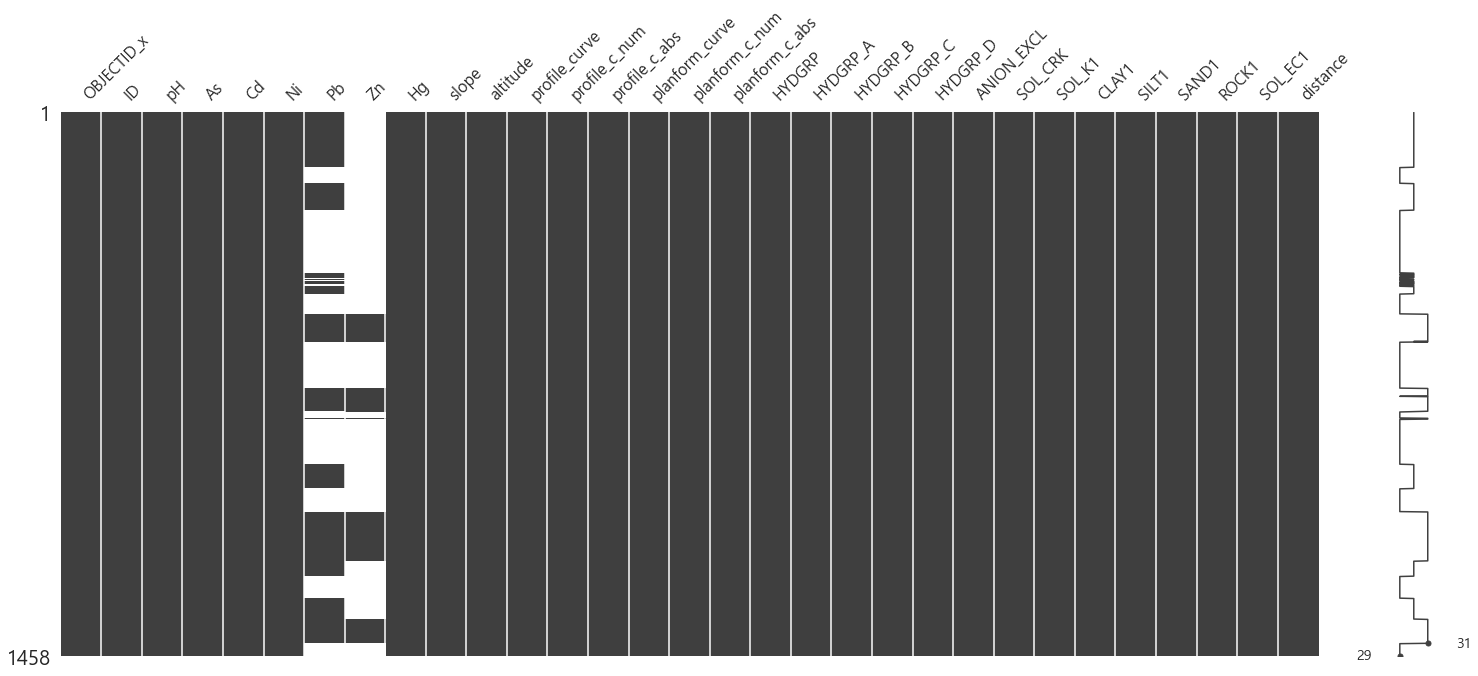

In [7]:
msno.matrix(data)

### YJ mine drop

In [5]:
yj_mine_data = data.loc[263:299,:]

In [6]:
yj_mine_data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1,distance
263,264,KW-YJ-PS-01,8.10,1.06,0.100,0.60,NaN,NaN,0.0,41.733299,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,13.175603
264,265,KW-YJ-PS-02,7.70,1.06,0.100,0.60,NaN,NaN,0.0,37.331100,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,12.951280
265,266,KW-YJ-PS-03,7.40,1.06,0.100,0.50,NaN,NaN,0.0,8.445270,...,0,0.5,0.5,12.03,17.0,46.0,37.0,14.0,0,12.036604
266,267,KW-YJ-S-04,5.65,0.25,0.060,3.17,NaN,NaN,0.0,11.050300,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,13.797559
267,268,KW-YJ-S-05,5.80,3.64,0.075,1.38,NaN,NaN,0.0,29.640400,...,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0,13.786335


In [7]:
for i in range(263, 300):
    data = data.drop(index = i)

In [8]:
data = data.drop(['ID'], axis = 1)
yj_mine_data = yj_mine_data.drop(['ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
yj_mine_data = yj_mine_data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)

### train / test split & eliminate outlier

In [9]:
def eli_outlier(data, value):
        q1 = data[value].quantile(0.25)
        q3 = data[value].quantile(0.75)
        
        iqr = q3 - q1
        
        q1_condition = data[value] < q1-1.5*iqr
        q3_condition = data[value] > q3+1.5*iqr
        
        reset_q1_index = data[q1_condition].index
        reset_q3_index = data[q3_condition].index
        
        data.drop(reset_q1_index, inplace = True)
        data.drop(reset_q3_index, inplace = True)        

In [10]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [11]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
# train

As_train = train.drop(['OBJECTID_x','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['OBJECTID_x','As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['OBJECTID_x','As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['OBJECTID_x','As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['OBJECTID_x','As','Cd','Ni','Pb','Hg'], axis=1)

eli_outlier(As_train, 'As')
eli_outlier(Cd_train, 'Cd')
eli_outlier(Ni_train, 'Ni')

In [12]:
# test

As_test = test
Cd_test = test
Ni_test = test

eli_outlier(As_test, 'As')
eli_outlier(Cd_test, 'Cd')
eli_outlier(Ni_test, 'Ni')

As_test_y = As_test.As
Cd_test_y = Cd_test.Cd
Ni_test_y = Ni_test.Ni

As_test = As_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_test = Cd_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_test = Ni_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [13]:
# yj mine

As_yj_mine_data = yj_mine_data
Cd_yj_mine_data = yj_mine_data
Ni_yj_mine_data = yj_mine_data

As_yj_mine_data = As_yj_mine_data.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_yj_mine_data = Cd_yj_mine_data.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_yj_mine_data = Ni_yj_mine_data.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [14]:
As_yj_value = yj_mine_data['As']
Cd_yj_value = yj_mine_data['Cd']
Ni_yj_value = yj_mine_data['Ni']

#### Log-Transformation

In [15]:
As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

As_test_y = np.log1p(As_test_y)
Cd_test_y = np.log1p(Cd_test_y)
Ni_test_y = np.log1p(Ni_test_y)

In [16]:
As_test_index = As_test.index
Cd_test_index = Cd_test.index
Ni_test_index = Ni_test.index

#### Scaling

In [17]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [18]:
scaler = StandardScaler()

scaler.fit(As_X)
As_X = pd.DataFrame(scaler.transform(As_X), columns=As_X.columns)
As_test = pd.DataFrame(scaler.transform(As_test), columns=As_test.columns)
As_yj_mine_data = pd.DataFrame(scaler.transform(As_yj_mine_data), columns=As_yj_mine_data.columns)

scaler.fit(Cd_X)
Cd_X = pd.DataFrame(scaler.transform(Cd_X), columns=Cd_X.columns)
Cd_test = pd.DataFrame(scaler.transform(Cd_test), columns=Cd_test.columns)
Cd_yj_mine_data = pd.DataFrame(scaler.transform(Cd_yj_mine_data), columns=Cd_yj_mine_data.columns)

scaler.fit(Ni_X)
Ni_X = pd.DataFrame(scaler.transform(Ni_X), columns=Ni_X.columns)
Ni_test = pd.DataFrame(scaler.transform(Ni_test), columns=Ni_test.columns)
Ni_yj_mine_data = pd.DataFrame(scaler.transform(Ni_yj_mine_data), columns=Ni_yj_mine_data.columns)

#### 10-Fold Crossvalidation

In [19]:
kf = KFold(n_splits = 10, random_state = 605, shuffle = True)

#### def R2 calculating

In [20]:
def SST(data, pred):
    sst = 0
    
    for i in range(0, len(pred)):
        sst += ((data[i] - np.mean(data))**2)
        
    return sst

def SSE(data, pred):
    sse = 0
    
    for i in range(0, len(pred)):
        sse += ((pred[i] - np.mean(data))**2)
        
    return sse

def SSR(data, pred):
    ssr = 0
    
    for i in range(0, len(data)):
        ssr += ((data[i] - pred[i])**2)
    
    return ssr

In [21]:
def cal_train_r2(pred, data):
    test = pd.DataFrame(data.values, columns=['real_value'])
    test['value'] = pred
    
    sse = SSE(test['real_value'], test['value'])
    ssr = SSR(test['real_value'], test['value'])
    sst = sse + ssr
    
    test_r2 = sse/sst
    
    return test_r2

def cal_val_r2(pred, data):
    test = pd.DataFrame()
    test['real_value'] = data
    test['value'] = pred
    
    sse = SSE(test['real_value'], test['value'])
    ssr = SSR(test['real_value'], test['value'])
    sst = sse + ssr
    
    test_r2 = SSE(test['real_value'], test['value'])/SST(test['real_value'], test['value'])
        
    return test_r2

def cal_val_r2_2(pred, data):
    test = pd.DataFrame()
    test['real_value'] = data
    test['value'] = pred
    
    sse = SSE(test['real_value'], test['value'])
    ssr = SSR(test['real_value'], test['value'])
    sst = sse + ssr
    
    test_r2 = sse/sst
        
    return test_r2

### Optuna Optimization

In [22]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

#### define optimization func

In [25]:
# As_X = X_train, As_y = y_train, As_test = X_test, As_test_y = y_test
# eval_set = [(X_test, y_test)],
# rmse = np.sqrt(mean_squared_error(gb.predict(X_test), y_test))
# r2 = r2_score(gb.predict(X_test), y_test)

def objectiveGB(trial: Trial, X_train, X_test, y_train, y_test) -> float:
    gb_paramas = {
        "random_state": 605,
        "learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.3, 0.7)
    }
    
    gb = GradientBoostingRegressor(**gb_paramas)
    gb.fit(
        X_train,
        y_train
    )
        
    r2 = cal_val_r2(np.array(gb.predict(X_test)), np.array(y_test))
    
    return r2

#### Optimization

In [26]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="gb_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveGB(trial, As_X, As_test, As_y, As_test_y), n_trials=50)
print("Best rmse Score: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-08-21 02:55:33,869] A new study created in memory with name: gb_parameter_opt
[I 2022-08-21 02:55:35,329] Trial 0 finished with value: 0.532808987246726 and parameters: {'n_estimators': 569, 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 3, 'subsample': 0.6978918238199414}. Best is trial 0 with value: 0.532808987246726.
[I 2022-08-21 02:55:37,253] Trial 1 finished with value: 0.5282613852629495 and parameters: {'n_estimators': 602, 'max_depth': 13, 'min_samples_leaf': 6, 'min_samples_split': 10, 'subsample': 0.5719977272751355}. Best is trial 0 with value: 0.532808987246726.
[I 2022-08-21 02:55:37,690] Trial 2 finished with value: 0.24157370004467643 and parameters: {'n_estimators': 855, 'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 3, 'subsample': 0.3296510026918827}. Best is trial 0 with value: 0.532808987246726.
[I 2022-08-21 02:55:38,261] Trial 3 finished with value: 0.49678304735362266 and parameters: {'n_estimators': 526, 'max_depth': 4, 'min_s

Best rmse Score:  0.6518107705451978
Best trial: {'n_estimators': 945, 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'subsample': 0.37093763219832315}


In [35]:
optuna.visualization.plot_param_importances(study)

#### GradientBoostingRegressor

In [211]:
""" normal model : 
    gb = GradientBoostingRegressor(random_state = 605, n_estimators = 1000, learning_rate = 0.1, max_depth = 30)
"""
""" tuned model : 
    gb = GradientBoostingRegressor(random_state = 605, n_estimators = 700, learning_rate = 0.1, max_depth = 4)

"""

def gb_model(test, mine, X, y):
    gb = GradientBoostingRegressor(random_state = 605, n_estimators = 945, learning_rate = 0.1,
                                   max_depth = 6, min_samples_leaf = 7, min_samples_split = 10,
                                   subsample = 0.2)
    
    gb_pred = np.zeros((test.shape[0]))
    mine_pred = np.zeros((mine.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        gb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in gb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        rmse_list.append(rmse)
        
        r2 = cal_val_r2(np.array(pred), np.array(np.expm1(val_y)))
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in gb.predict(test)]) / 9
        sub_pred_2 = np.expm1([0 if x < 0 else x for x in gb.predict(mine)]) / 9
        
        gb_pred += sub_pred
        mine_pred += sub_pred_2
    
    print(f'Validation {gb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Validation {gb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')
    
    return gb_pred, mine_pred

def gb_train_model(X, y):
    gb = GradientBoostingRegressor(random_state = 605, n_estimators = 945, learning_rate = 0.1,
                                   max_depth = 6, min_samples_leaf = 7, min_samples_split = 10,
                                   subsample = 0.2)
    
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        gb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in gb.predict(tr_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(tr_y), pred))
        rmse_list.append(rmse)
        
        r2 = cal_val_r2(np.array(pred), np.array(np.expm1(tr_y)))
        r2_list.append(r2)
    
    print(f'Train {gb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}')
    print(f'Train {gb.__class__.__name__}의 20fold 평균 R2는 {np.mean(r2_list)}')

In [212]:
As_gb_pred, As_gb_mine_pred = gb_model(As_test, As_yj_mine_data, As_X, As_y)

Validation GradientBoostingRegressor의 20fold 평균 RMSE는 0.9893834991885655
Validation GradientBoostingRegressor의 20fold 평균 R2는 0.5748847942770186


In [213]:
gb_train_model(As_X, As_y)

Train GradientBoostingRegressor의 20fold 평균 RMSE는 0.18480985543538966
Train GradientBoostingRegressor의 20fold 평균 R2는 0.8547772237551742


In [164]:
Cd_gb_pred, Cd_gb_mine_pred = gb_model(Cd_test, Cd_yj_mine_data, Cd_X, Cd_y)

Validation GradientBoostingRegressor의 20fold 평균 RMSE는 0.06981448191718817
Validation GradientBoostingRegressor의 20fold 평균 R2는 0.6654354197765999


In [165]:
gb_train_model(Cd_X, Cd_y)

Train GradientBoostingRegressor의 20fold 평균 RMSE는 0.014588007752542691
Train GradientBoostingRegressor의 20fold 평균 R2는 0.8584743060037819


In [144]:
Ni_gb_pred, Ni_gb_mine_pred = gb_model(Ni_test, Ni_yj_mine_data, Ni_X, Ni_y)

Validation GradientBoostingRegressor의 20fold 평균 RMSE는 8.486436535452896
Validation GradientBoostingRegressor의 20fold 평균 R2는 0.7536996665380624


In [121]:
gb_train_model(Ni_X, Ni_y)

Train GradientBoostingRegressor의 20fold 평균 RMSE는 3.783968604864363
Train GradientBoostingRegressor의 20fold 평균 R2는 0.8481093872348575


###  Evaluate Models

In [214]:
# test
#As
gb_As_test = pd.DataFrame()

#Cd
gb_Cd_test = pd.DataFrame()

#Ni
gb_Ni_test = pd.DataFrame()


In [123]:
# mine
#As
mine_gb_As_test = pd.DataFrame()

#Cd
mine_gb_Cd_test = pd.DataFrame()

#Ni
mine_gb_Ni_test = pd.DataFrame()

In [215]:
# test
gb_As_test['As_value'] = As_gb_pred
gb_Cd_test['Cd_value'] = Cd_gb_pred
gb_Ni_test['Ni_value'] = Ni_gb_pred

In [107]:
# mine
mine_gb_As_test['As_value'] = As_gb_mine_pred
mine_gb_Cd_test['Cd_value'] = Cd_gb_mine_pred
mine_gb_Ni_test['Ni_value'] = Ni_gb_mine_pred

#### def quantile scailing

In [168]:
def data_scailing(test, value):
    q1 = test[value].quantile(0.004)
    q2 = test[value].quantile(0.99)
    
    test[value] = test[value].apply(lambda x: x if x > q1 else x * 0.9)
    test[value] = test[value].apply(lambda x: x if x < q2 else x * 1.1)
    
    return test

In [216]:
# test
# As
gb_As_test = data_scailing(gb_As_test, 'As_value')

# Cd
gb_Cd_test = data_scailing(gb_Cd_test, 'Cd_value')

# Ni
gb_Ni_test = data_scailing(gb_Ni_test, 'Ni_value')

In [110]:
# mine
# As
mine_gb_As_test = data_scailing(mine_gb_As_test, 'As_value')

# Cd
mine_gb_Cd_test = data_scailing(mine_gb_Cd_test, 'Cd_value')

# Ni
mine_gb_Ni_test = data_scailing(mine_gb_Ni_test, 'Ni_value')

In [217]:
# test
gb_As_test['index'] = As_test_index

gb_Cd_test['index'] = Cd_test_index

gb_Ni_test['index'] = Ni_test_index

In [218]:
for index in gb_As_test['index']:
    gb_As_test.loc[gb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']

for index in gb_Cd_test['index']:
    gb_Cd_test.loc[gb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    
for index in gb_Ni_test['index']:
    gb_Ni_test.loc[gb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']

In [113]:
# mine
# As
mine_gb_As_test['As_real_value'] = As_yj_value.values

# Cd
mine_gb_Cd_test['Cd_real_value'] = Cd_yj_value.values

# Ni
mine_gb_Ni_test['Ni_real_value'] = Ni_yj_value.values

#### R2 scoring & RMSE

In [219]:
def cal_r2_score(list, value, pred_value):
    r2_list = []
    model_list = ['GradientBoost']
    index = 0
    
    for item in list:
        r2_list.append(SSE(item[value], item[pred_value])/SST(item[value], item[pred_value]))
    
    for item in r2_list:
        print(model_list[index]+' '+pred_value+' R2 score : '+str(item))
        index += 1

In [220]:
def cal_rmse(list, value, pred_value):
    rmse_list = []
    index = 0
    model_list = ['GradientBoost']
    
    for item in list:
        rmse_list.append(np.sqrt(mean_squared_error(item[value], item[pred_value])))
        
    for item in rmse_list:
        print(model_list[index]+' '+pred_value+' RMSE : '+str(item))
        index += 1

In [221]:
# test
r2_As_list = [gb_As_test]
r2_Cd_list = [gb_Cd_test]
r2_Ni_list = [gb_Ni_test]

# mine
r2_mine_As_list = [mine_gb_As_test]
r2_mine_Cd_list = [mine_gb_Cd_test]
r2_mine_Ni_list = [mine_gb_Ni_test]

#### test

In [222]:
cal_r2_score(r2_As_list, 'As_real_value', 'As_value')

GradientBoost As_value R2 score : 0.5539133283170751


In [223]:
cal_rmse(r2_As_list, 'As_real_value', 'As_value')

GradientBoost As_value RMSE : 0.8640241267069757


In [175]:
cal_r2_score(r2_Cd_list, 'Cd_real_value', 'Cd_value')

GradientBoost Cd_value R2 score : 0.5801472160738863


In [176]:
cal_rmse(r2_Cd_list, 'Cd_real_value', 'Cd_value')

GradientBoost Cd_value RMSE : 0.0692796907270866


In [153]:
cal_r2_score(r2_Ni_list, 'Ni_real_value', 'Ni_value')

GradientBoost Ni_value R2 score : 0.6901229169904158


In [154]:
cal_rmse(r2_Ni_list, 'Ni_real_value', 'Ni_value')

GradientBoost Ni_value RMSE : 7.602635380620577


### Visualization

#### test

In [92]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,14)},
        style='darkgrid',
       )

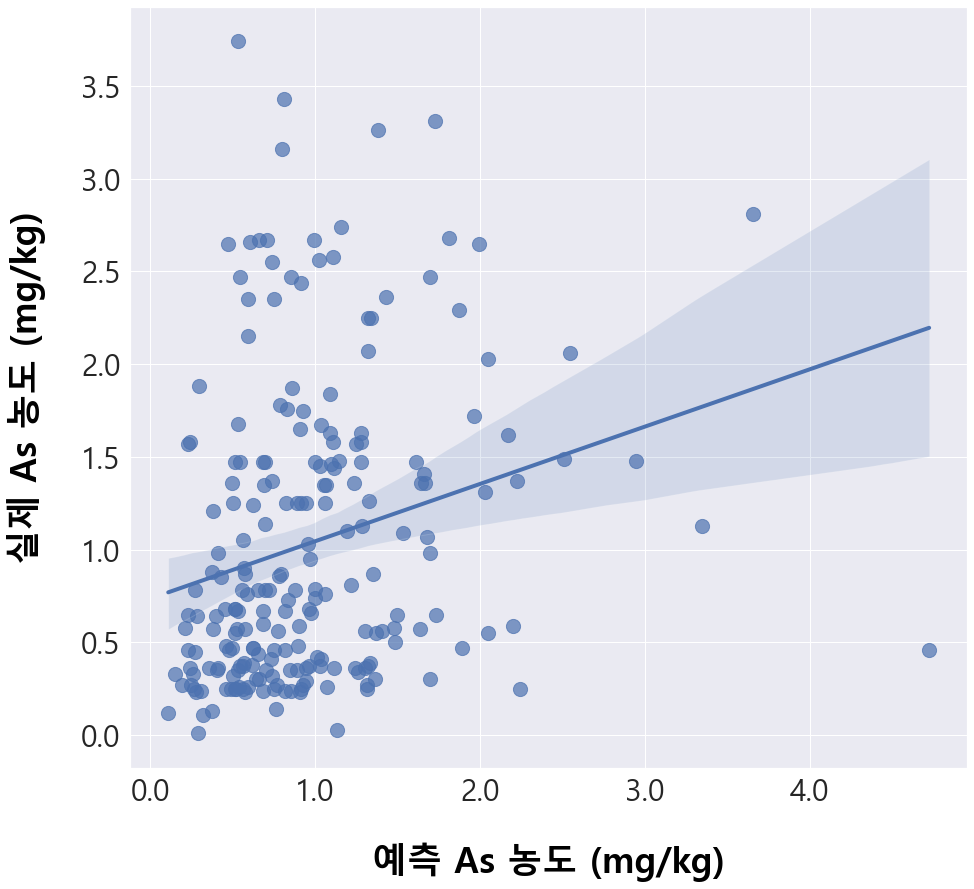

In [93]:
#plt.title('NGBregressor를 이용하여 예측한 As의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
#plt.scatter(ngb_As_test['As_value'], ngb_As_test['As_real_value'], marker='D', alpha=0.5)
plt.xticks(fontsize = 30)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.yticks(fontsize = 30)
sns.regplot(ngb_As_test['As_value'], ngb_As_test['As_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 As 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 As 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

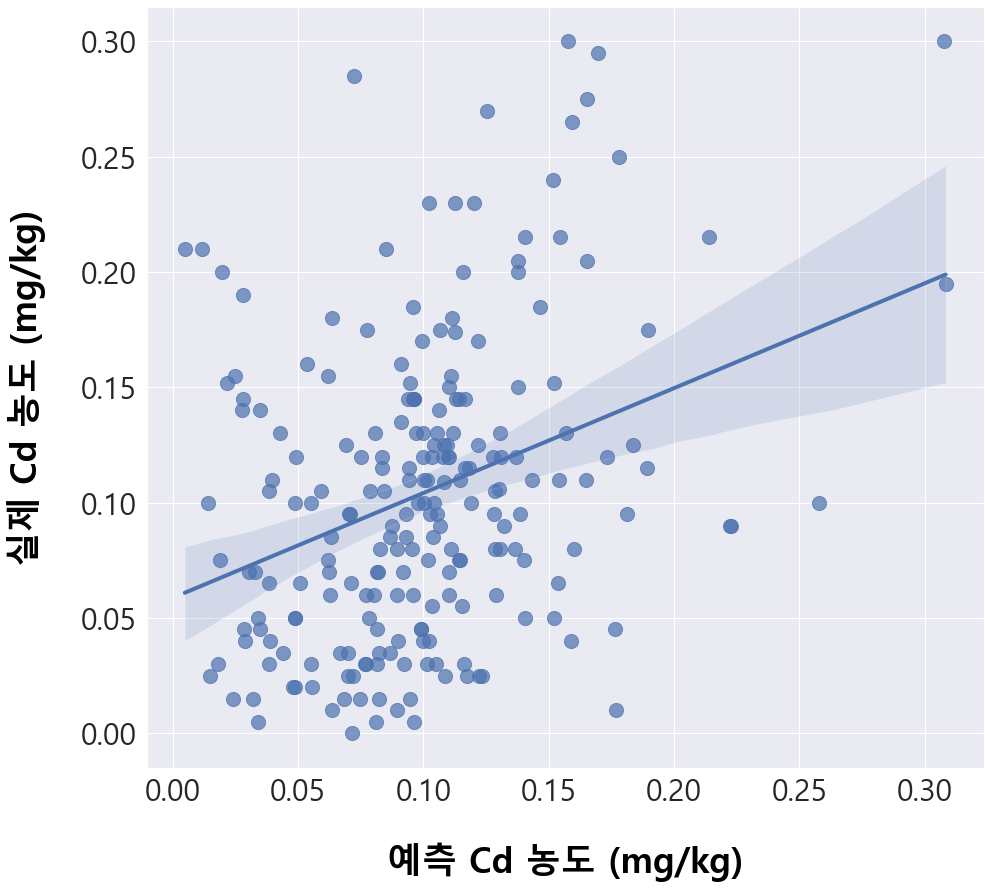

In [94]:
#plt.title('GradientBoostRegressor를 이용하여 예측한 Cd의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
#plt.scatter(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'], marker='D', alpha=0.5)
plt.xticks(fontsize = 30)
#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.yticks(fontsize = 30)
sns.regplot(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 Cd 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 Cd 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

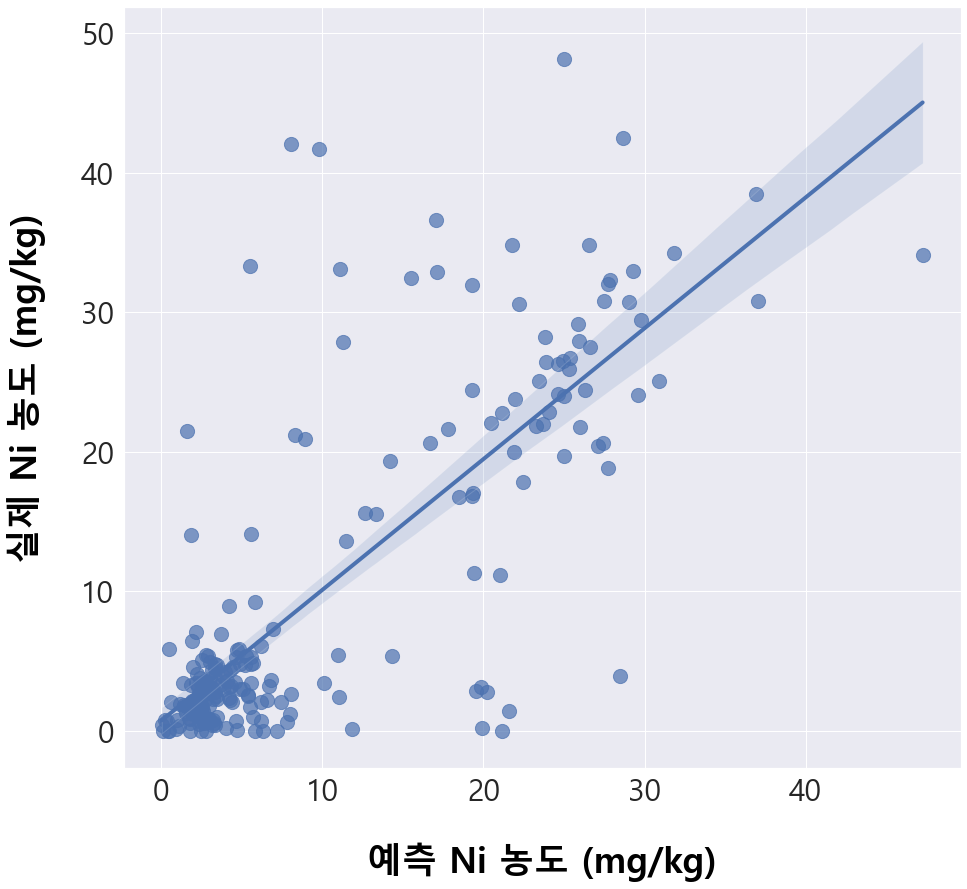

In [95]:
#plt.title('GradientBoostRegressor를 이용하여 예측한 Ni의 선형 그래프', fontdict={'color': 'black', 'weight': 'bold', 'size': 25}, pad=40)
#plt.scatter(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'], marker='D', alpha=0.5)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
sns.regplot(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'], scatter_kws={'s': 200, 'alpha': 0.7}, line_kws={'linewidth':4})
plt.xlabel('예측 Ni 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.ylabel('실제 Ni 농도 (mg/kg)', fontdict={'color': 'black', 'size': 35, 'weight': 'bold'}, labelpad=35)
plt.show()

---

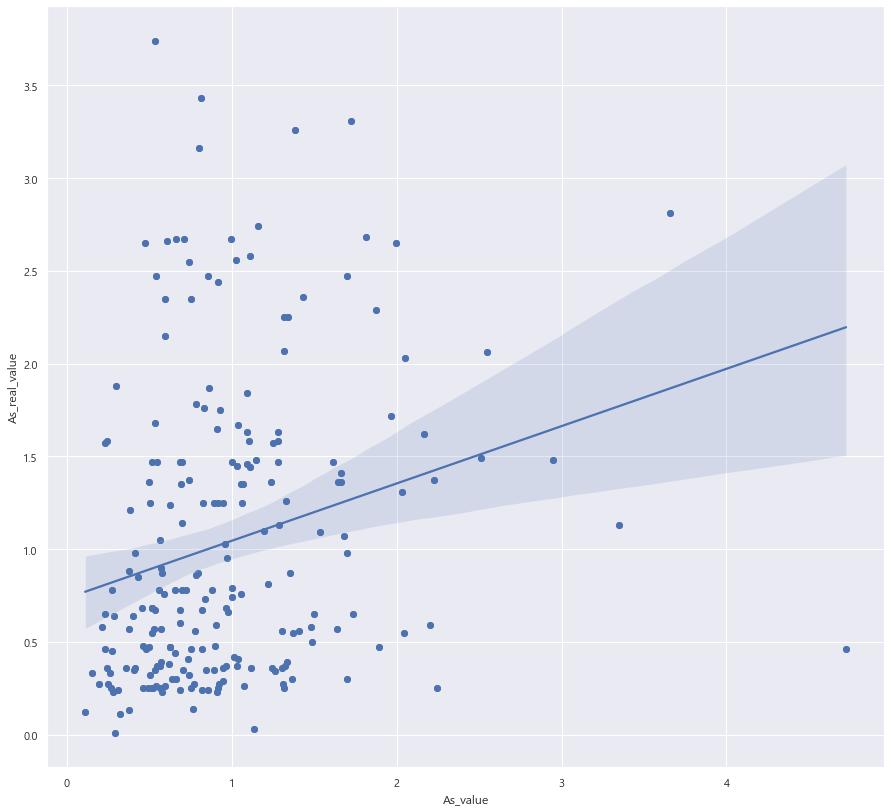

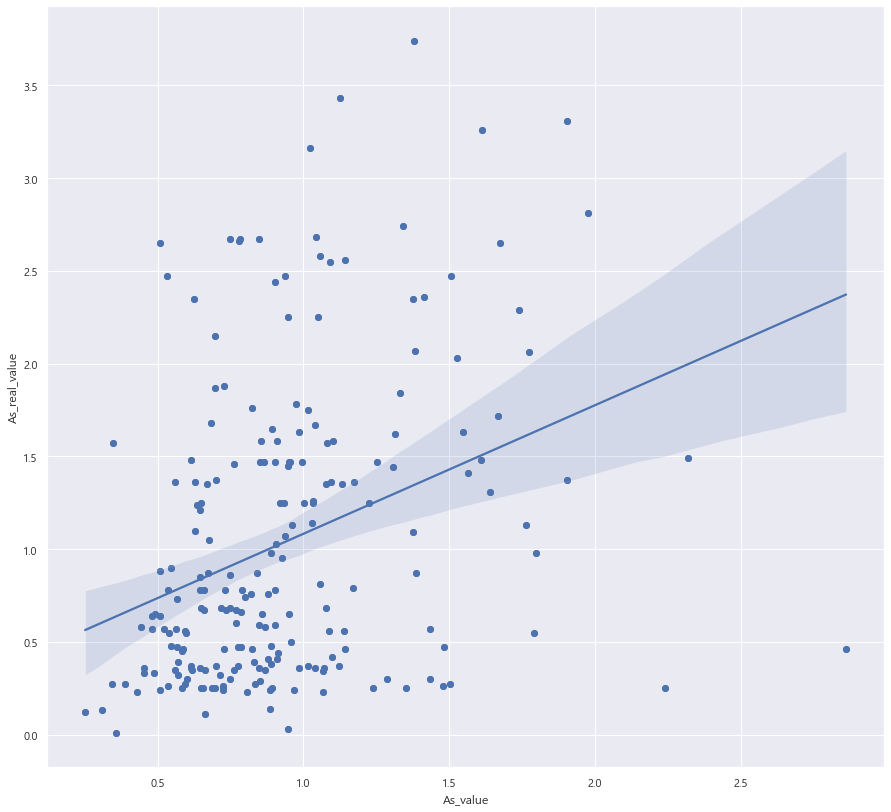

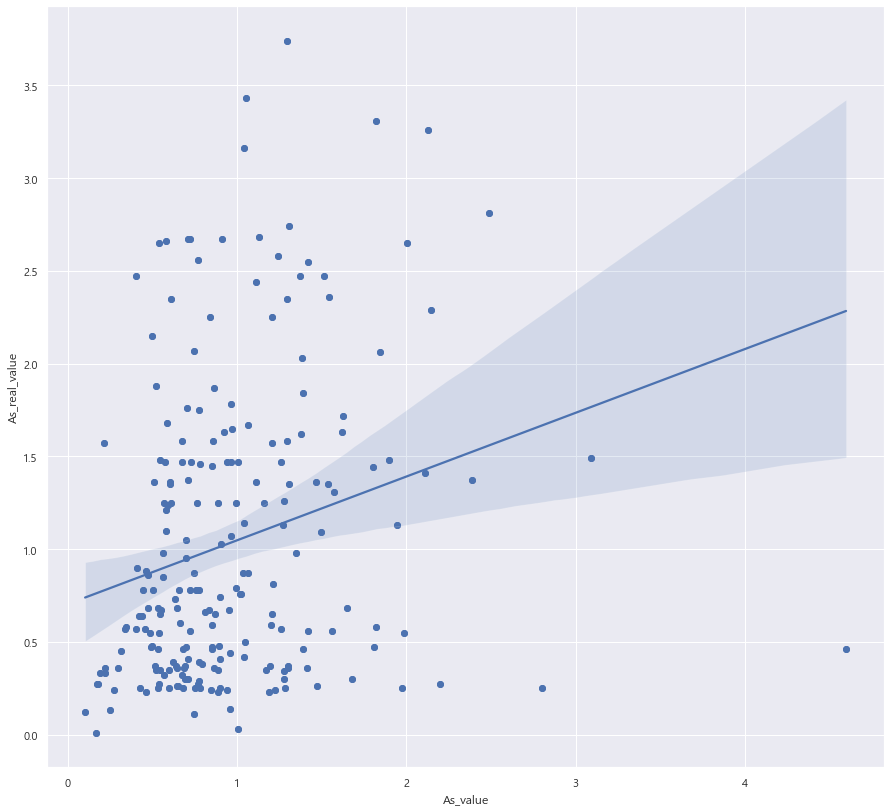

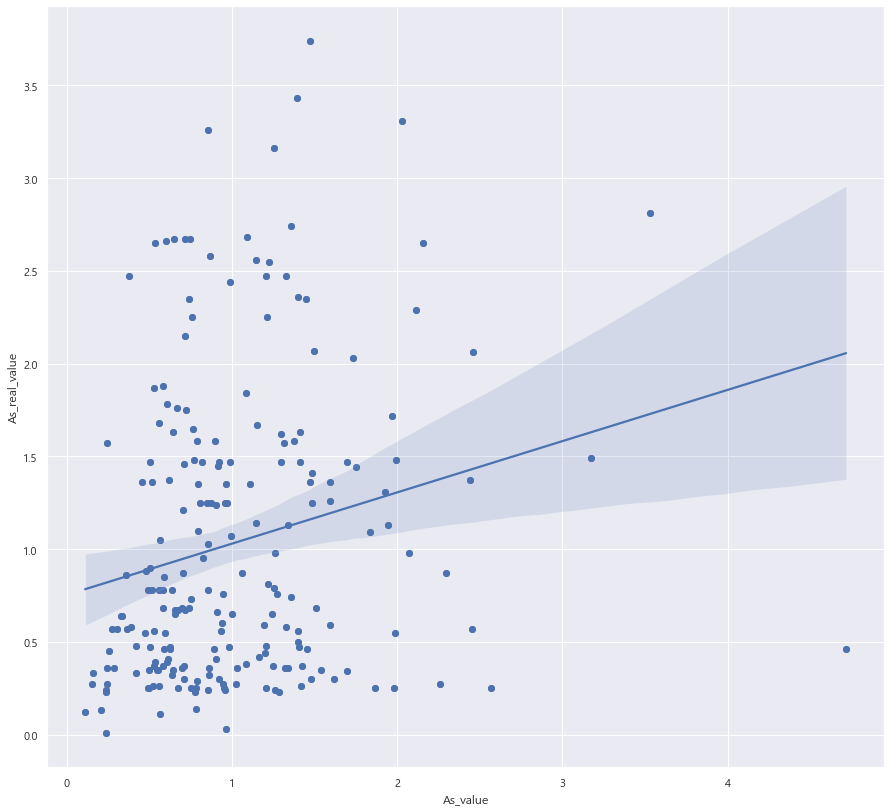

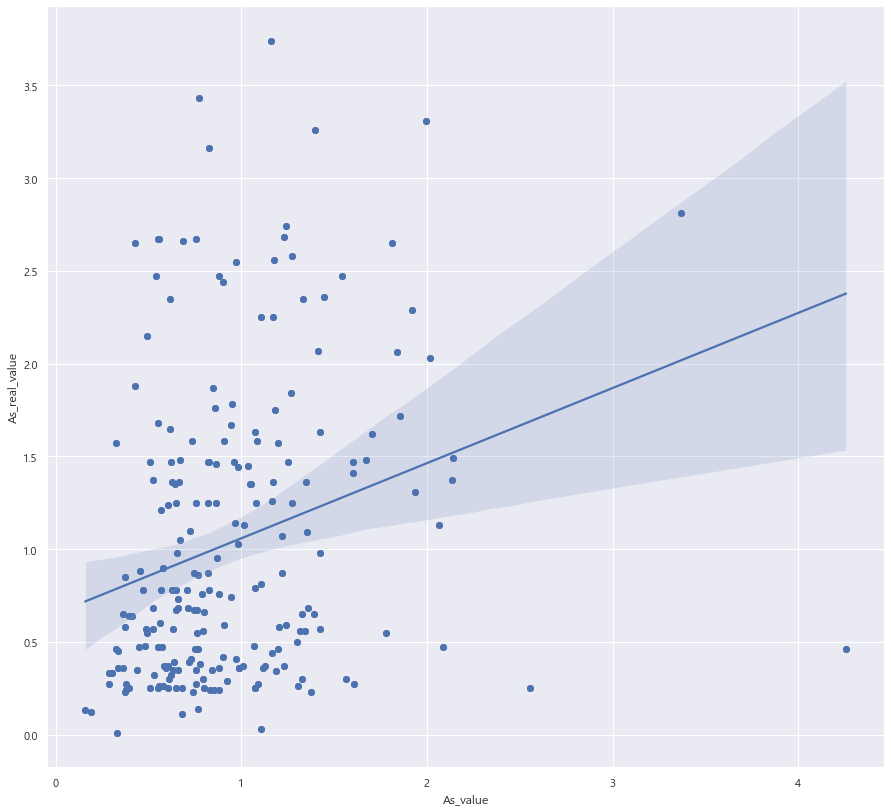

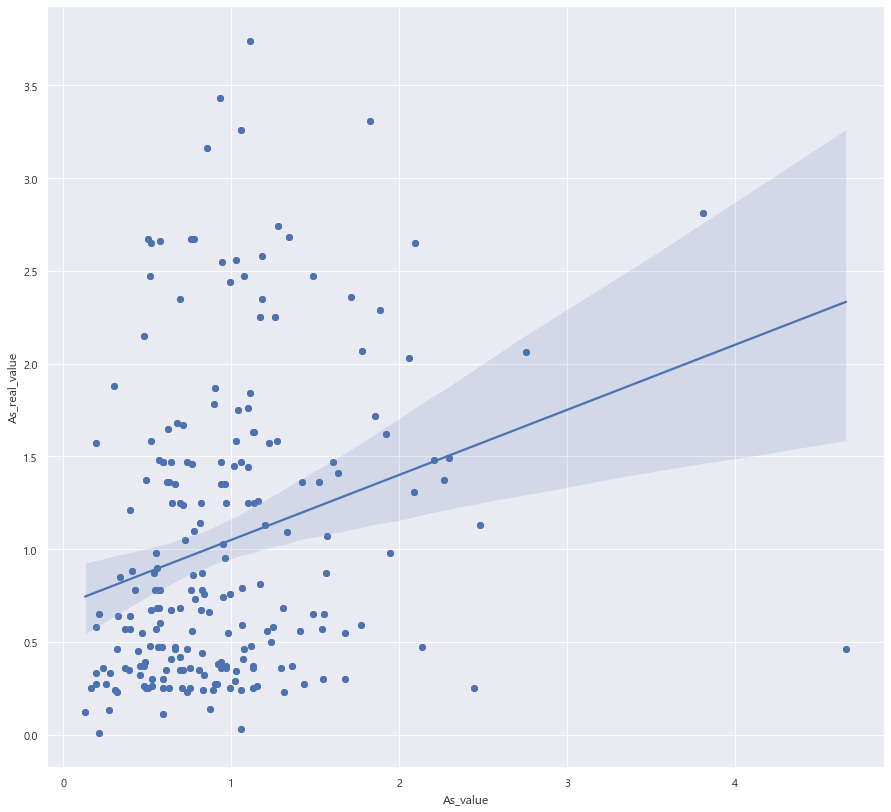

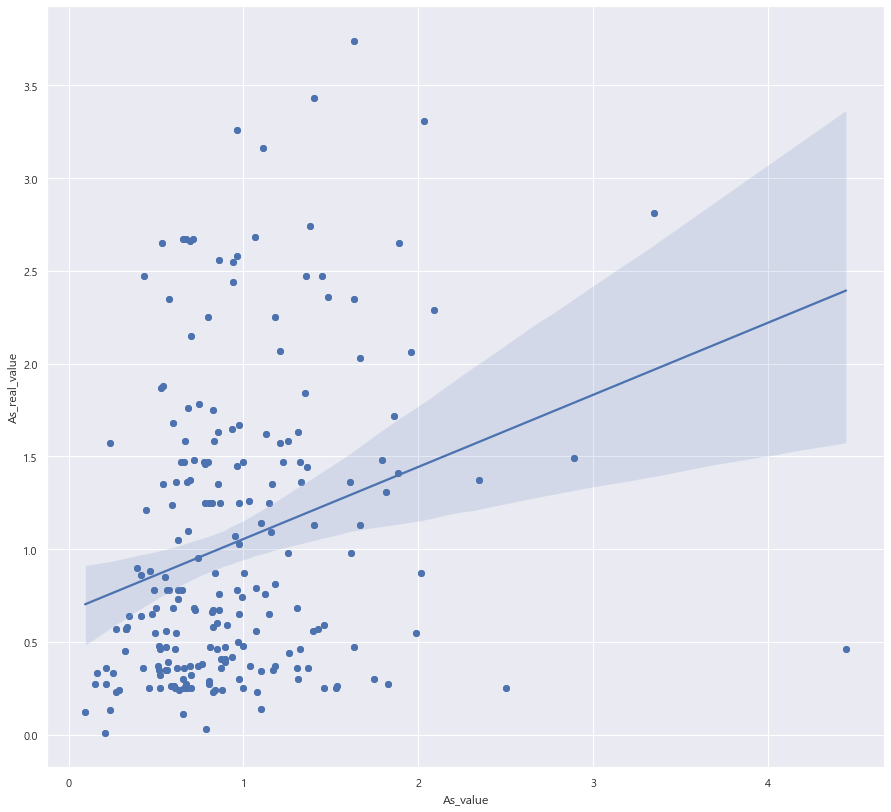

In [96]:
plt.scatter(ngb_As_test['As_value'], ngb_As_test['As_real_value'])
sns.regplot(ngb_As_test['As_value'], ngb_As_test['As_real_value'])
plt.show()

plt.scatter(rf_As_test['As_value'], rf_As_test['As_real_value'])
sns.regplot(rf_As_test['As_value'], rf_As_test['As_real_value'])
plt.show()

plt.scatter(etc_As_test['As_value'], etc_As_test['As_real_value'])
sns.regplot(etc_As_test['As_value'], etc_As_test['As_real_value'])
plt.show()

plt.scatter(gb_As_test['As_value'], gb_As_test['As_real_value'])
sns.regplot(gb_As_test['As_value'], gb_As_test['As_real_value'])
plt.show()

plt.scatter(cb_As_test['As_value'], cb_As_test['As_real_value'])
sns.regplot(cb_As_test['As_value'], cb_As_test['As_real_value'])
plt.show()

plt.scatter(lgbm_As_test['As_value'], lgbm_As_test['As_real_value'])
sns.regplot(lgbm_As_test['As_value'], lgbm_As_test['As_real_value'])
plt.show()

plt.scatter(xgb_As_test['As_value'], xgb_As_test['As_real_value'])
sns.regplot(xgb_As_test['As_value'], xgb_As_test['As_real_value'])
plt.show()

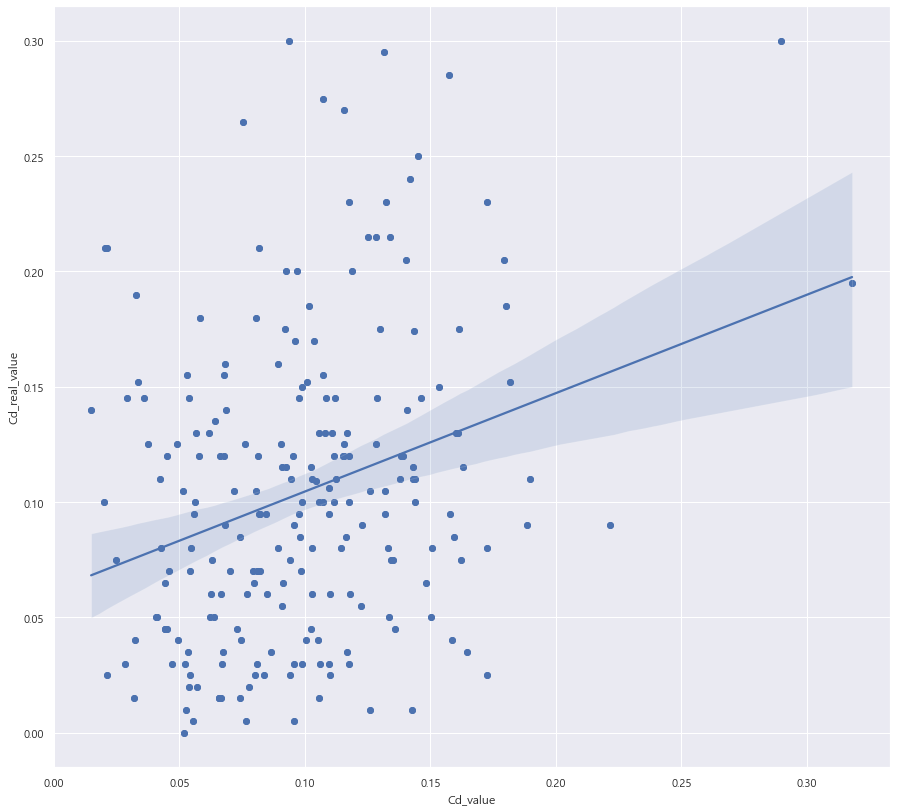

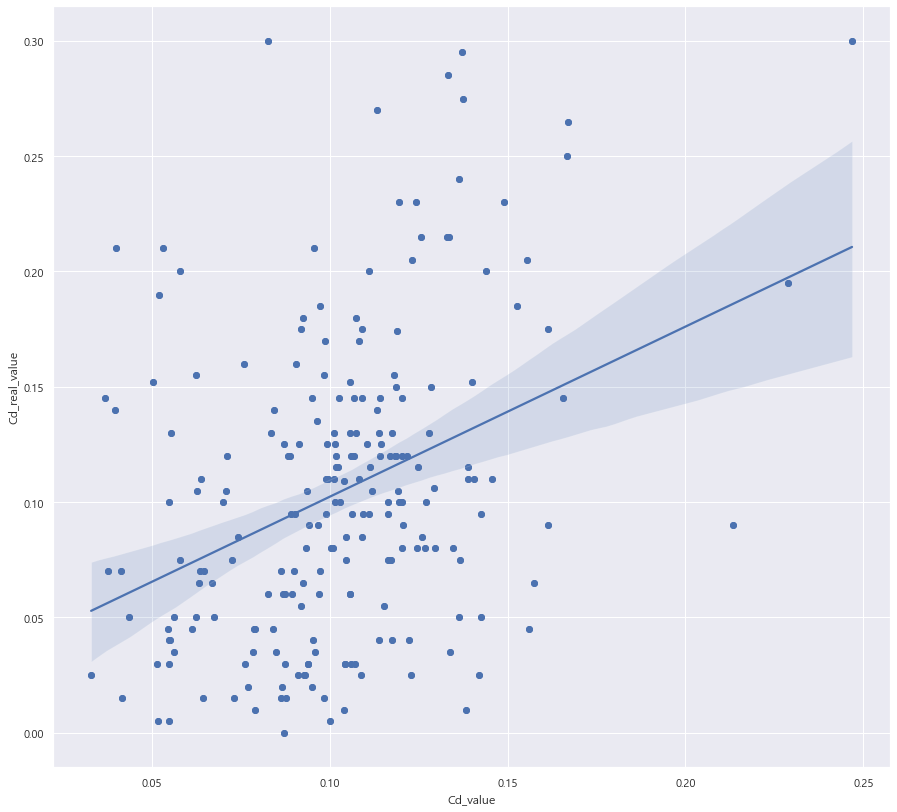

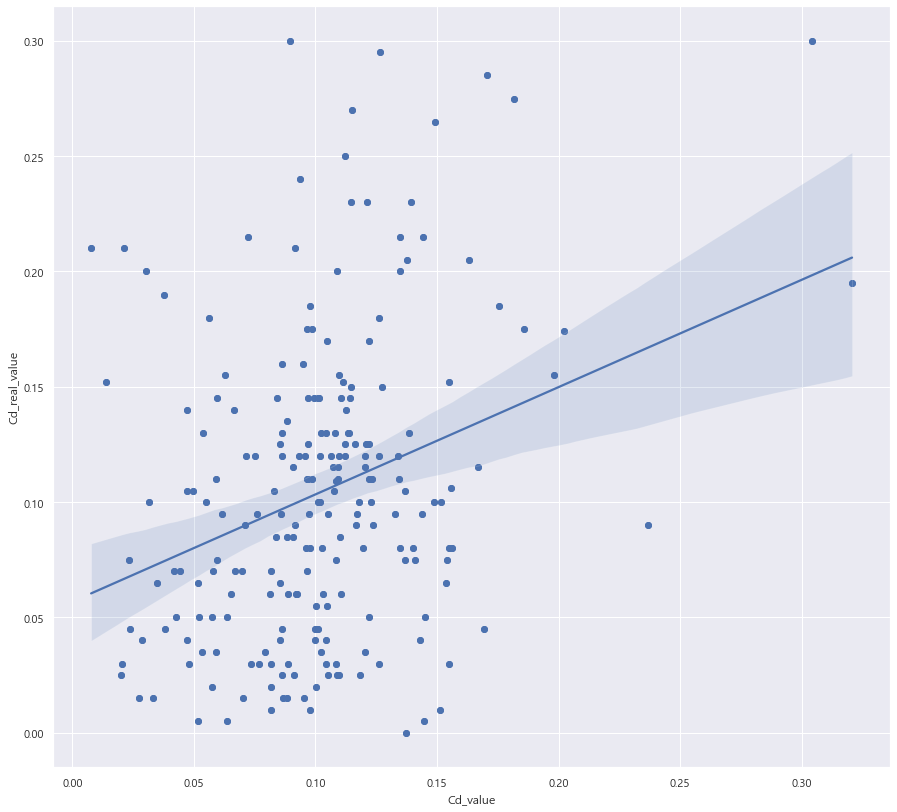

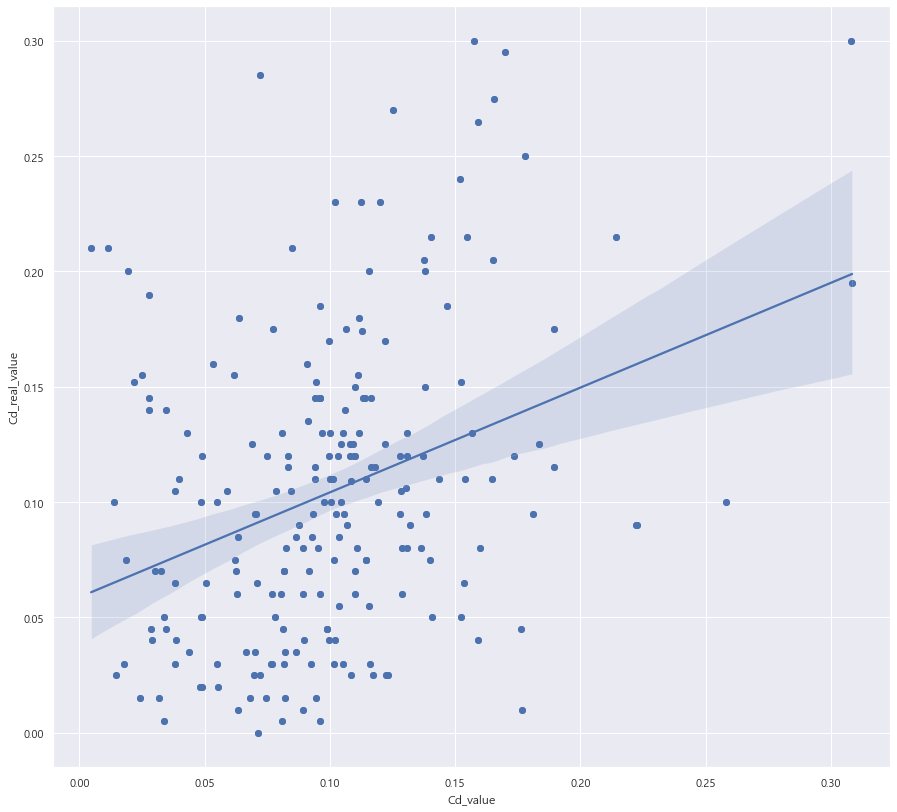

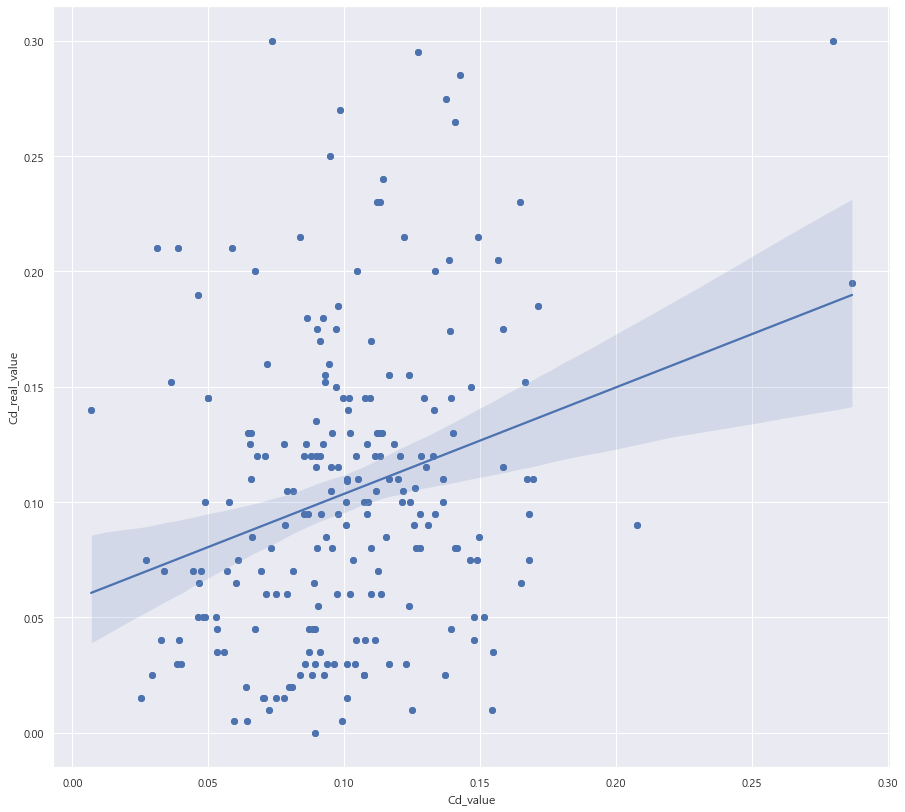

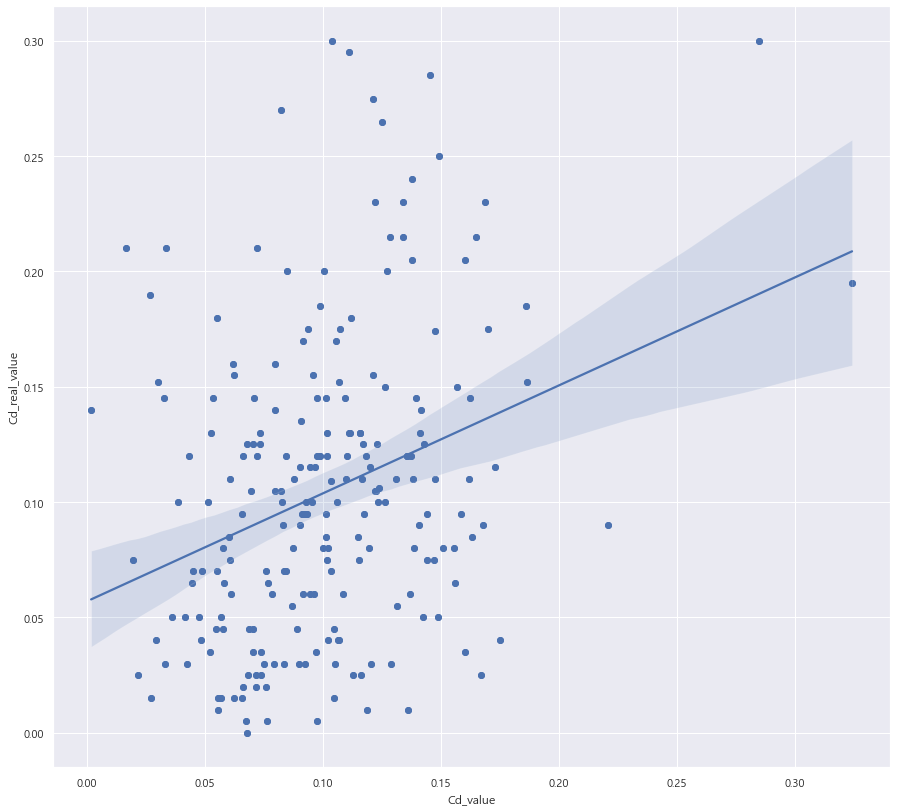

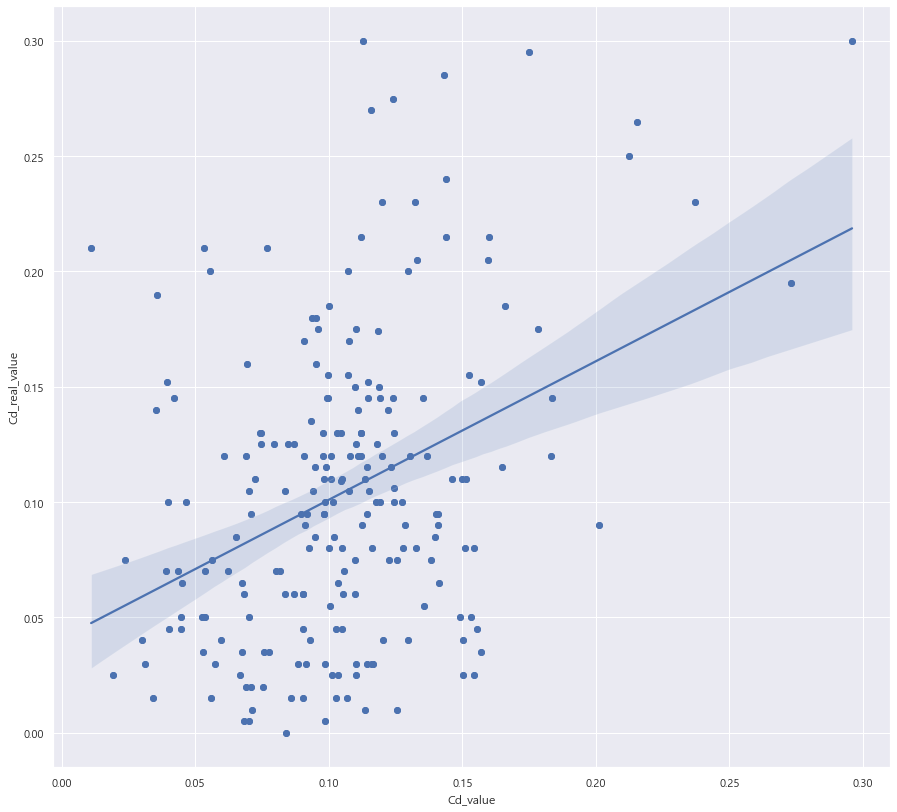

In [97]:
plt.scatter(ngb_Cd_test['Cd_value'], ngb_Cd_test['Cd_real_value'])
sns.regplot(ngb_Cd_test['Cd_value'], ngb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(rf_Cd_test['Cd_value'], rf_Cd_test['Cd_real_value'])
sns.regplot(rf_Cd_test['Cd_value'], rf_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(etc_Cd_test['Cd_value'], etc_Cd_test['Cd_real_value'])
sns.regplot(etc_Cd_test['Cd_value'], etc_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'])
sns.regplot(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(cb_Cd_test['Cd_value'], cb_Cd_test['Cd_real_value'])
sns.regplot(cb_Cd_test['Cd_value'], cb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(lgbm_Cd_test['Cd_value'], lgbm_Cd_test['Cd_real_value'])
sns.regplot(lgbm_Cd_test['Cd_value'], lgbm_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(xgb_Cd_test['Cd_value'], xgb_Cd_test['Cd_real_value'])
sns.regplot(xgb_Cd_test['Cd_value'], xgb_Cd_test['Cd_real_value'])
plt.show()

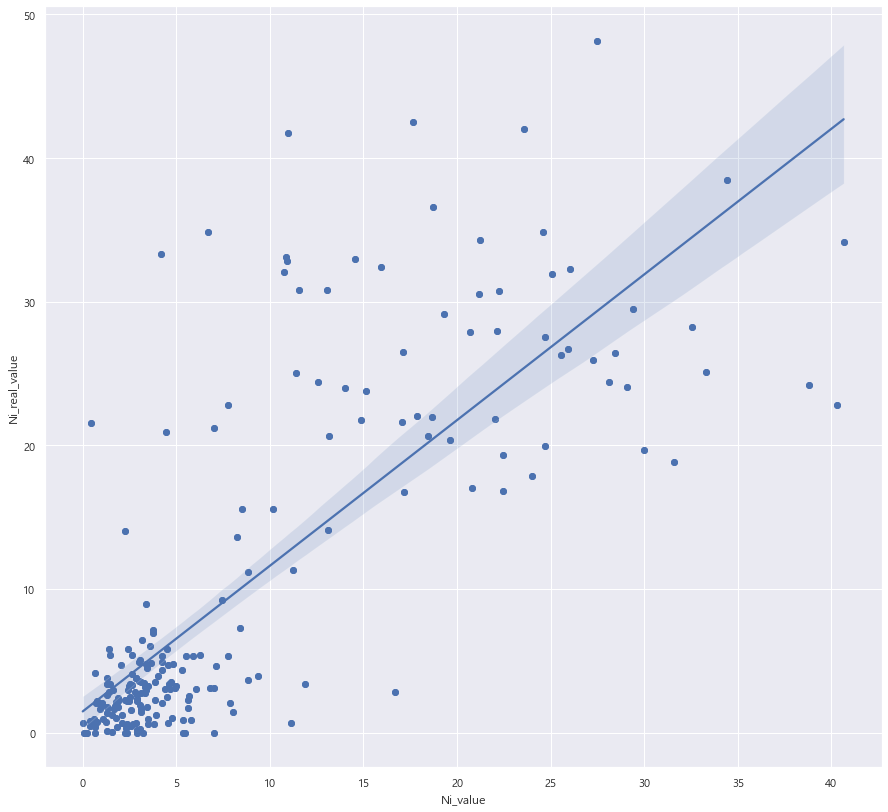

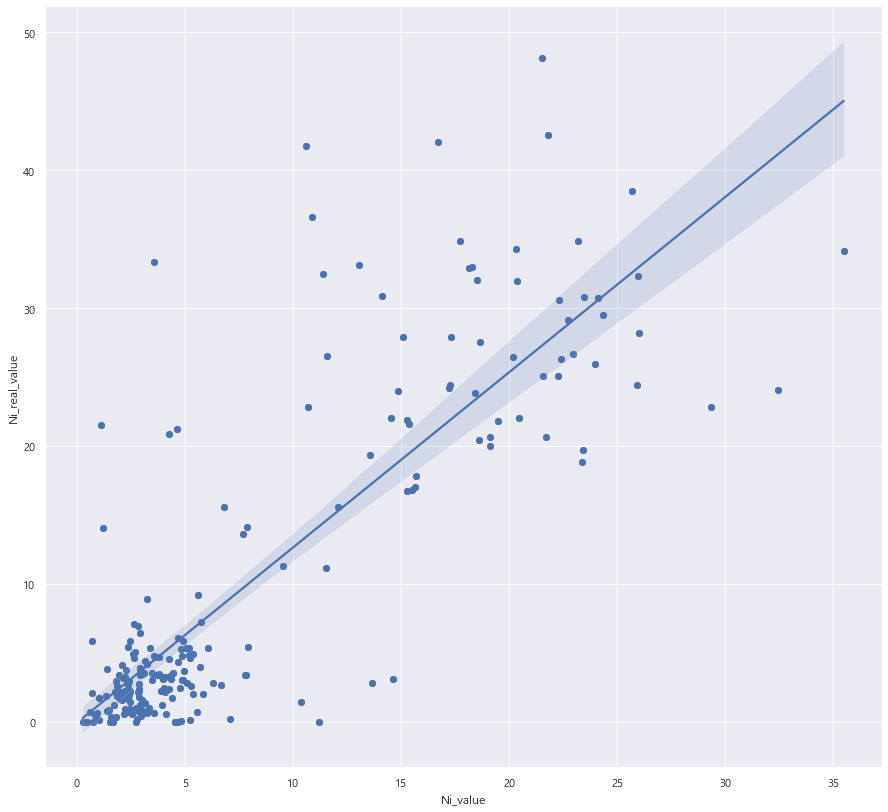

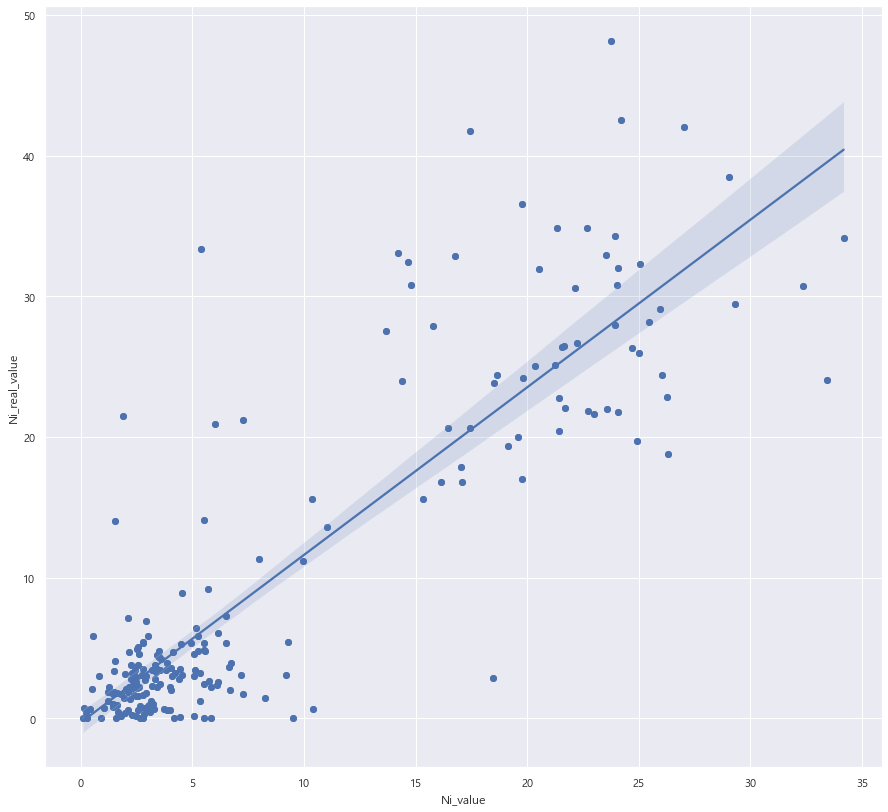

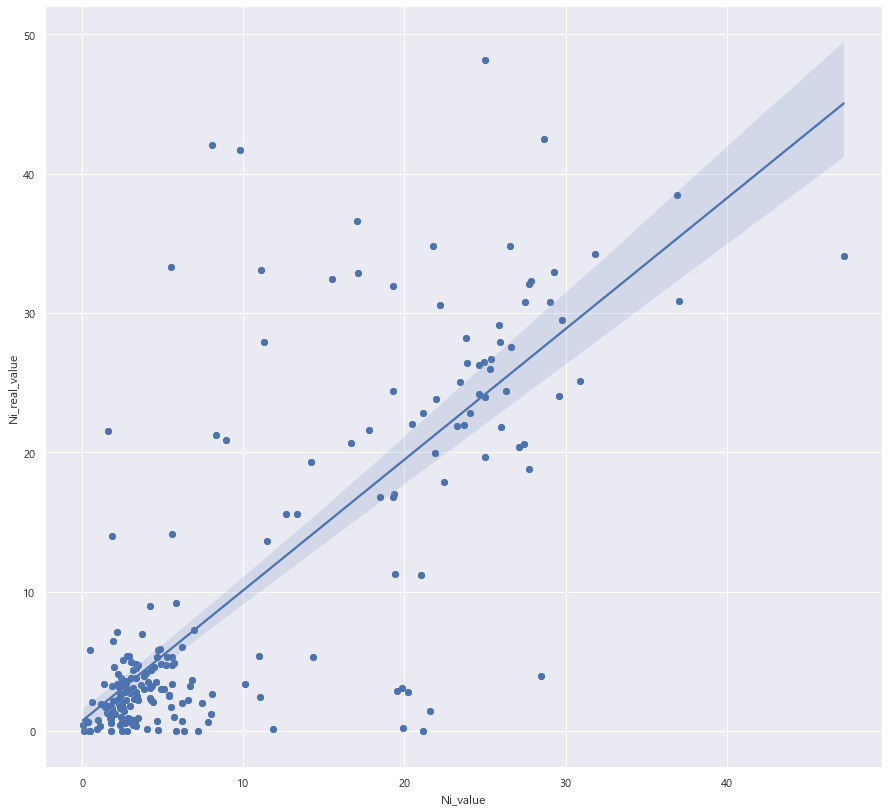

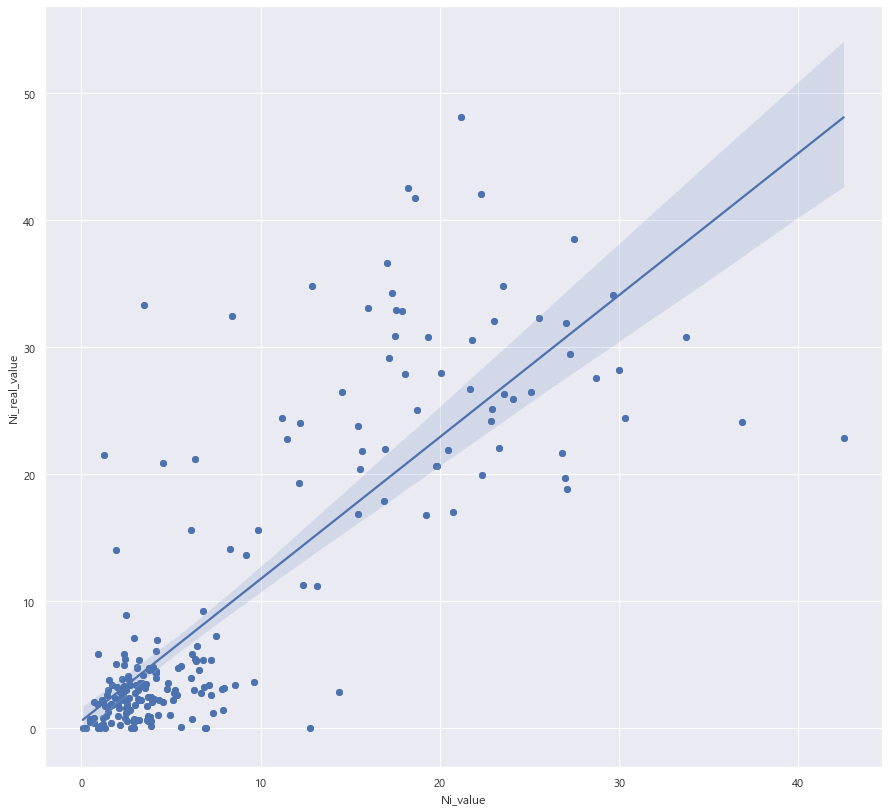

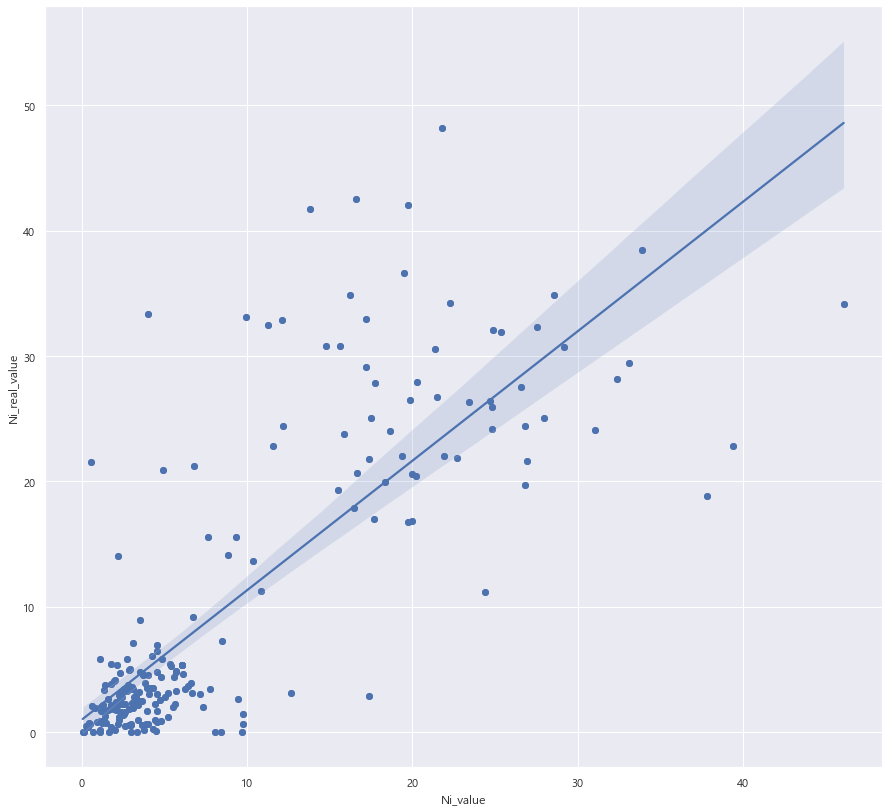

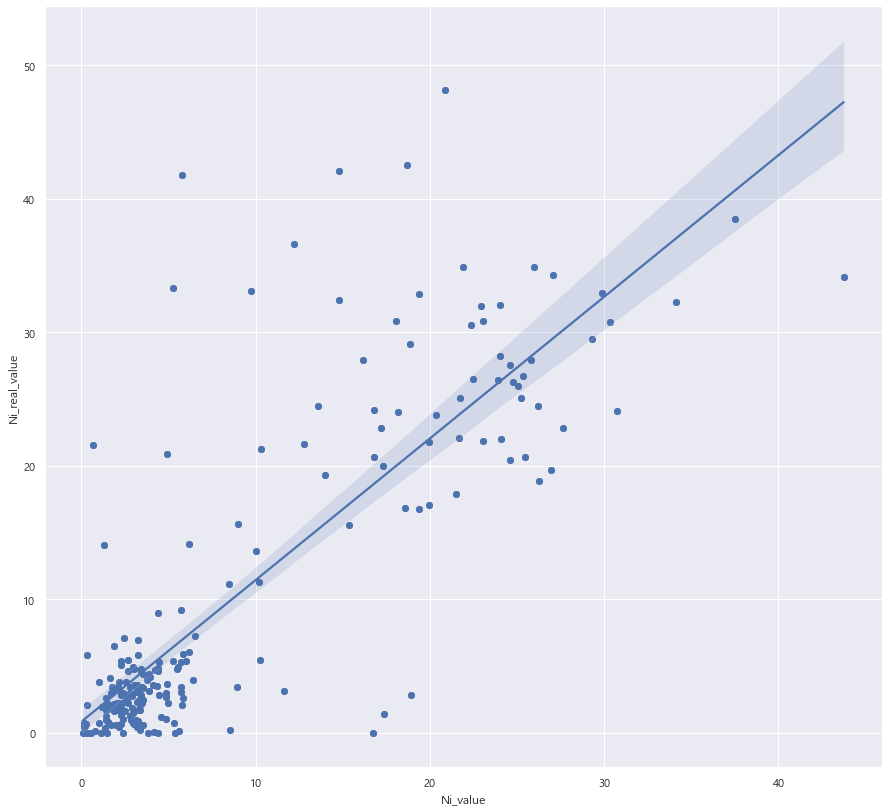

In [98]:
plt.scatter(ngb_Ni_test['Ni_value'], ngb_Ni_test['Ni_real_value'])
sns.regplot(ngb_Ni_test['Ni_value'], ngb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(rf_Ni_test['Ni_value'], rf_Ni_test['Ni_real_value'])
sns.regplot(rf_Ni_test['Ni_value'], rf_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(etc_Ni_test['Ni_value'], etc_Ni_test['Ni_real_value'])
sns.regplot(etc_Ni_test['Ni_value'], etc_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'])
sns.regplot(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(cb_Ni_test['Ni_value'], cb_Ni_test['Ni_real_value'])
sns.regplot(cb_Ni_test['Ni_value'], cb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(lgbm_Ni_test['Ni_value'], lgbm_Ni_test['Ni_real_value'])
sns.regplot(lgbm_Ni_test['Ni_value'], lgbm_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(xgb_Ni_test['Ni_value'], xgb_Ni_test['Ni_real_value'])
sns.regplot(xgb_Ni_test['Ni_value'], xgb_Ni_test['Ni_real_value'])
plt.show()